In [1]:
library(reticulate)
sagemaker <- import('sagemaker')

In [2]:
role_arn <- sagemaker$get_execution_role()

In [3]:
session <- sagemaker$Session()
bucket <- session$default_bucket()
prefix <- ''

In [4]:
library(readr)
data_file <- 's3://partly-cloudy-common-area/hourly_issr_summary.csv'
mydata <- read_csv(file = sagemaker$s3$S3Downloader$read_file(data_file,
                                                              sagemaker_session= session),
                   col_names = TRUE)

In [5]:
df <- as.data.frame(mydata)

In [6]:
head(df)

,index,dateTime,iSSRs,floor,ceiling
,<dbl>,<dttm>,<dbl>,<dbl>,<dbl>
1,7900,2020-06-01 00:00:00,7406,23564.34,41293.3
2,7205,2020-06-01 01:00:00,7250,23564.34,41293.3
3,1910,2020-06-01 02:00:00,6401,23564.34,41293.3
4,8435,2020-06-01 03:00:00,6448,23564.34,41293.3
5,3739,2020-06-01 04:00:00,7185,23564.34,41293.3
6,502,2020-06-01 05:00:00,7429,23564.34,41293.3


Sources:

http://r-statistics.co/Top50-Ggplot2-Visualizations-MasterList-R-Code.html#Bar%20Chart

http://rstudio-pubs-static.s3.amazonaws.com/392033_47b565c44b8246fca23a255bc59beabd.html

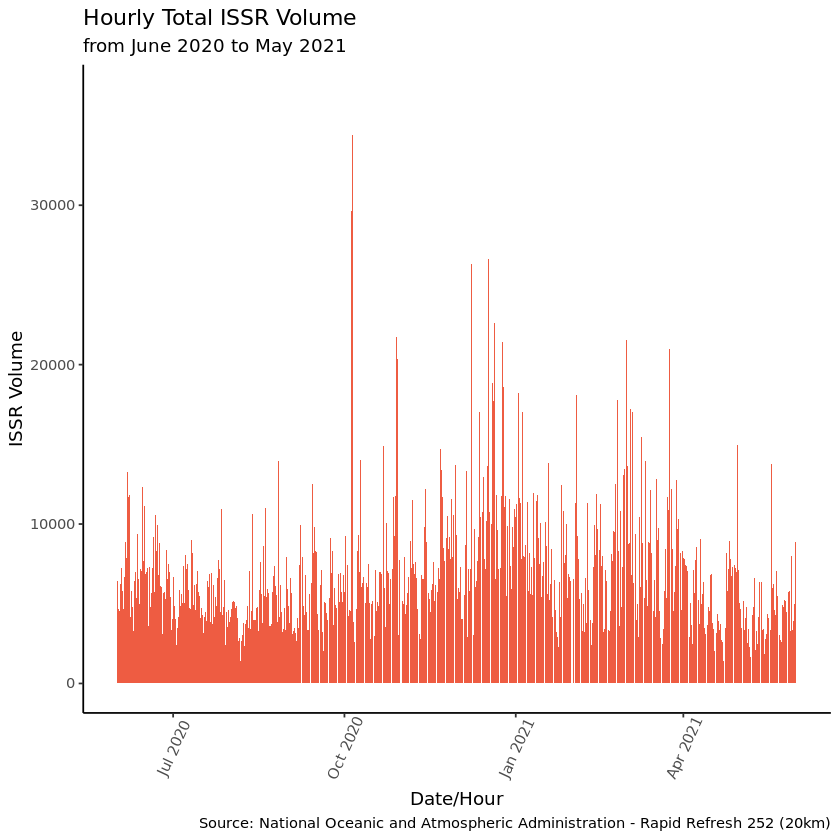

In [21]:
# plot
library(ggplot2)
library(dplyr)
theme_set(theme_classic())

# Plot
g <- ggplot(df, aes(dateTime, iSSRs))
g + geom_col(fill= "tomato2") + 
    labs(title= "Hourly Total ISSR Volume",
         subtitle= "from June 2020 to May 2021",
         caption= "Source: National Oceanic and Atmospheric Administration - Rapid Refresh 252 (20km)",
         x= "Date/Hour", 
         y= "ISSR Volume") +
theme(axis.text.x = element_text(angle=65, vjust=0.6))

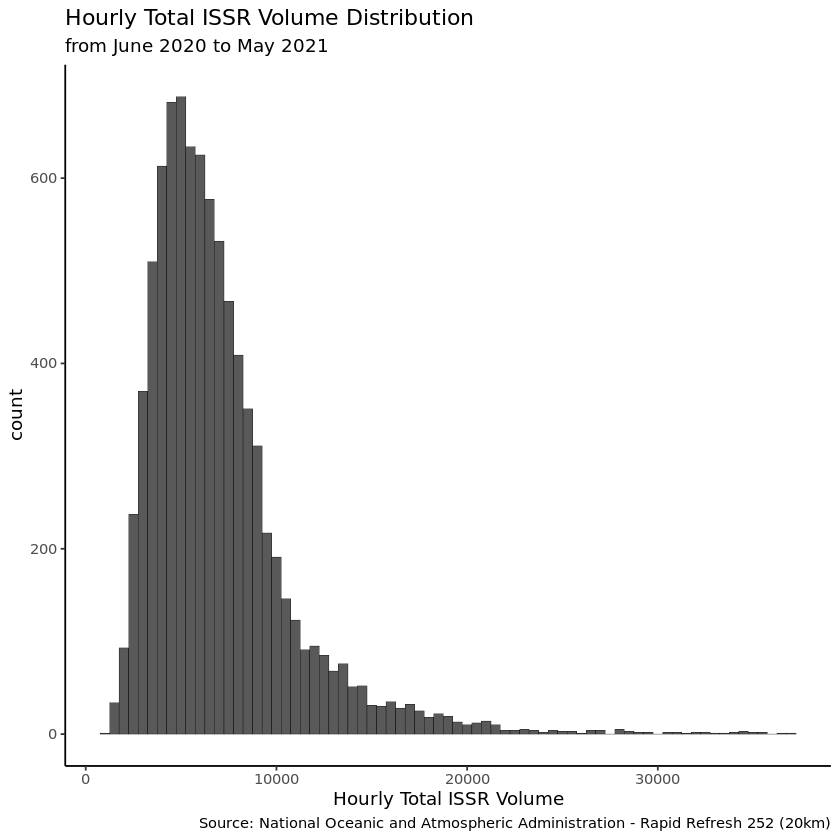

In [22]:
g <- ggplot(df, aes(iSSRs)) + scale_fill_brewer(palette= "Spectral")
g + geom_histogram(#aes(fill=class), 
                   binwidth = 500, 
                   col= "black", 
                   size= .1) +  # change binwidth
  labs(title="Hourly Total ISSR Volume Distribution", 
       subtitle="from June 2020 to May 2021",
       x= "Hourly Total ISSR Volume", 
       caption= "Source: National Oceanic and Atmospheric Administration - Rapid Refresh 252 (20km)")  

In [23]:
library(lubridate)
df$mon <- month(df$dateTime, label= TRUE)

Warning message:
“Your system is mis-configured: ‘/etc/localtime’ is not a symlink”
Warning message:
“It is strongly recommended to set envionment variable TZ to ‘Etc/UCT’ (or equivalent)”

Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [24]:
head(df)

,index,dateTime,iSSRs,floor,ceiling,mon
,<dbl>,<dttm>,<dbl>,<dbl>,<dbl>,<ord>
1,7900,2020-06-01 00:00:00,7406,23564.34,41293.3,Jun
2,7205,2020-06-01 01:00:00,7250,23564.34,41293.3,Jun
3,1910,2020-06-01 02:00:00,6401,23564.34,41293.3,Jun
4,8435,2020-06-01 03:00:00,6448,23564.34,41293.3,Jun
5,3739,2020-06-01 04:00:00,7185,23564.34,41293.3,Jun
6,502,2020-06-01 05:00:00,7429,23564.34,41293.3,Jun


In [25]:
month_total <- df %>% group_by(mon) %>% summarize(monthlyiSSRs = sum(iSSRs, na.rm= TRUE))

In [26]:
month_total

mon,monthlyiSSRs
<ord>,<dbl>
Jan,6427921
Feb,5121588
Mar,6287976
Apr,3948918
May,3403485
Jun,4917631
Jul,4075105
Aug,3827339
Sep,4041602


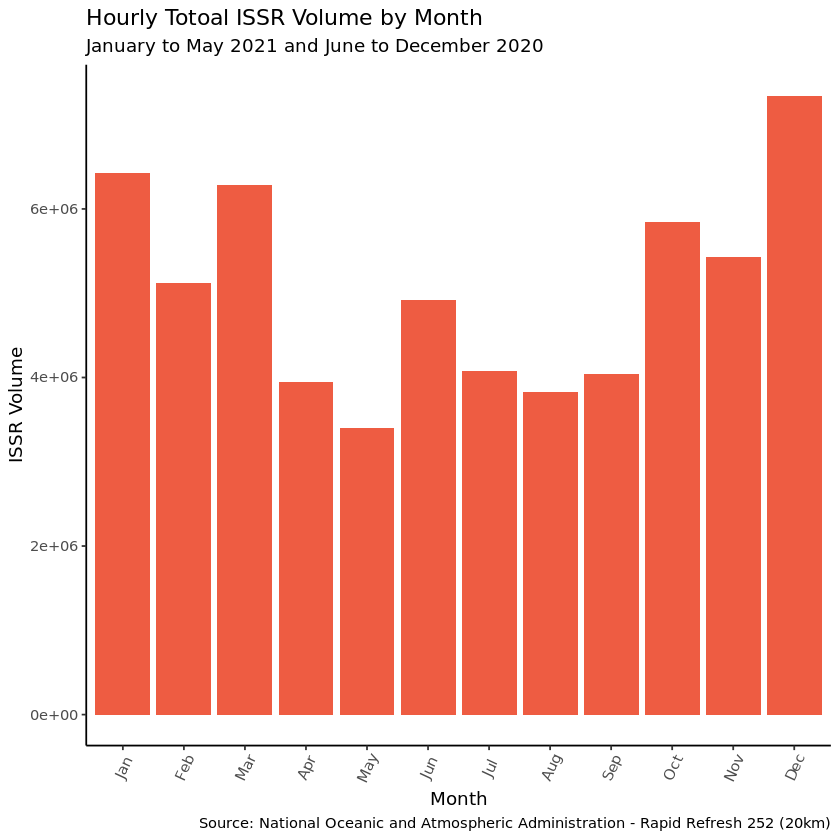

In [27]:
# Plot
g <- ggplot(month_total, aes(mon, monthlyiSSRs))
g + geom_col(fill= "tomato2") + 
    labs(title= "Hourly Totoal ISSR Volume by Month",
         subtitle= "January to May 2021 and June to December 2020",
         caption= "Source: National Oceanic and Atmospheric Administration - Rapid Refresh 252 (20km)",
         x= "Month", 
         y= "ISSR Volume") +
theme(axis.text.x = element_text(angle=65, vjust=0.6))

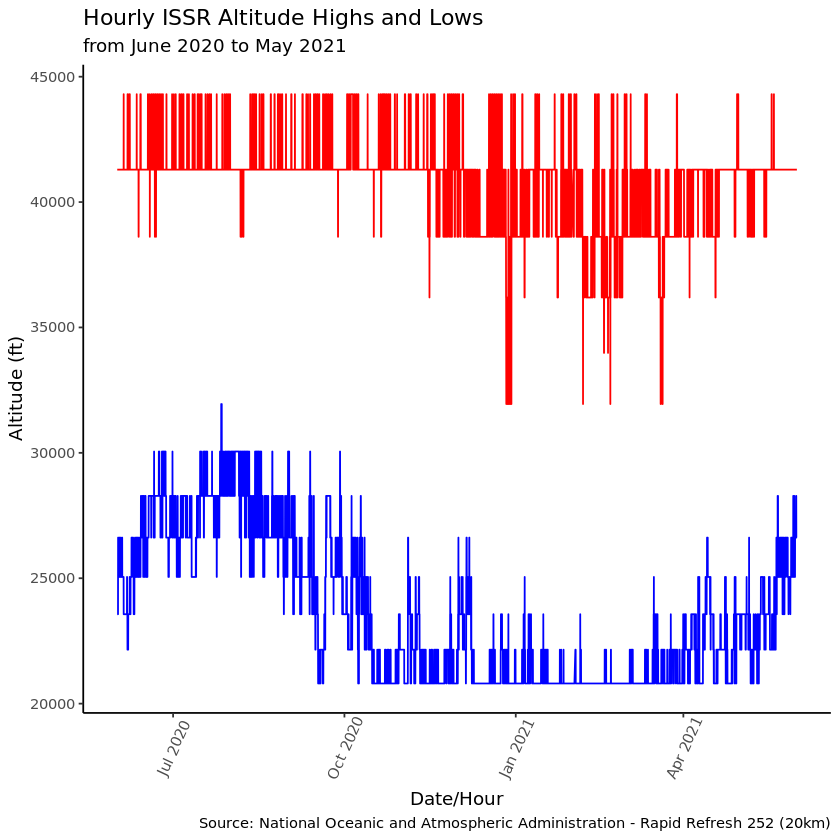

In [29]:
# Allow Default X Axis Labels
ggplot(df, aes(x= dateTime)) + 
  geom_line(aes(y= floor), color= 'blue') + geom_line(aes(y= ceiling), color= 'red') + 
  labs(title= "Hourly ISSR Altitude Highs and Lows", 
       subtitle= "from June 2020 to May 2021", 
       caption= "Source: National Oceanic and Atmospheric Administration - Rapid Refresh 252 (20km)",
       x= "Date/Hour",
       y= "Altitude (ft)") +
theme(axis.text.x = element_text(angle= 65, vjust= 0.6))

In [30]:
df_copy <- df

In [31]:
df_copy$dateTime_lag6 = df_copy$dateTime - hours(6)
df_copy$dateTime_lag12 = df_copy$dateTime - hours(12)
df_copy$dateTime_lag24 = df_copy$dateTime - hours(24)

In [32]:
df_join <- df_copy %>% inner_join(df, c('dateTime_lag6' = 'dateTime'), suffix= c('', '_6'))
df_join <- df_join %>% inner_join(df, c('dateTime_lag12' = 'dateTime'), suffix= c('', '_12'))
df_join <- df_join %>% inner_join(df, c('dateTime_lag24' = 'dateTime'), suffix= c('', '_24'))

df_join$volChange_6 <- (df_join$iSSRs - df_join$iSSRs_6)/df_join$iSSRs_6
df_join$volChange_12 <- (df_join$iSSRs - df_join$iSSRs_12)/df_join$iSSRs_12
df_join$volChange_24 <- (df_join$iSSRs - df_join$iSSRs_24)/df_join$iSSRs_24

In [33]:
head(df_join)

,index,dateTime,iSSRs,floor,ceiling,mon,dateTime_lag6,dateTime_lag12,dateTime_lag24,index_6,⋯,ceiling_12,mon_12,index_24,iSSRs_24,floor_24,ceiling_24,mon_24,volChange_6,volChange_12,volChange_24
,<dbl>,<dttm>,<dbl>,<dbl>,<dbl>,<ord>,<dttm>,<dttm>,<dttm>,<dbl>,⋯,<dbl>,<ord>,<dbl>,<dbl>,<dbl>,<dbl>,<ord>,<dbl>,<dbl>,<dbl>
1,1220,2020-06-02 00:00:00,7638,25051.00,41293.3,Jun,2020-06-01 18:00:00,2020-06-01 12:00:00,2020-06-01 00:00:00,6154,⋯,41293.3,Jun,7900,7406,23564.34,41293.3,Jun,0.48686004,-0.085926281,0.03132595
2,5781,2020-06-02 01:00:00,6599,25051.00,41293.3,Jun,2020-06-01 19:00:00,2020-06-01 13:00:00,2020-06-01 01:00:00,8372,⋯,41293.3,Jun,7205,7250,23564.34,41293.3,Jun,0.22955096,-0.239045203,-0.08979310
3,6263,2020-06-02 02:00:00,5839,25051.00,41293.3,Jun,2020-06-01 20:00:00,2020-06-01 14:00:00,2020-06-01 02:00:00,5962,⋯,41293.3,Jun,1910,6401,23564.34,41293.3,Jun,-0.01600944,-0.353806994,-0.08779878
4,3608,2020-06-02 03:00:00,6003,25051.00,41293.3,Jun,2020-06-01 21:00:00,2020-06-01 15:00:00,2020-06-01 03:00:00,1623,⋯,41293.3,Jun,8435,6448,23564.34,41293.3,Jun,-0.17597804,-0.279351741,-0.06901365
5,8093,2020-06-02 04:00:00,5409,25051.00,41293.3,Jun,2020-06-01 22:00:00,2020-06-01 16:00:00,2020-06-01 04:00:00,5730,⋯,41293.3,Jun,3739,7185,23564.34,41293.3,Jun,-0.29099489,0.158988644,-0.24718163
6,3089,2020-06-02 05:00:00,4538,26620.21,41293.3,Jun,2020-06-01 23:00:00,2020-06-01 17:00:00,2020-06-01 05:00:00,3159,⋯,41293.3,Jun,502,7429,23564.34,41293.3,Jun,-0.41976729,0.002872928,-0.38915063


In [34]:
sapply(df_join[,25:27], mean)

volChange_6 volChange_12 volChange_24 
  0.09720805   0.11095886   0.10880701

In [35]:
sapply(df_join[,25:27], sd)

volChange_6 volChange_12 volChange_24 
   0.4857126    0.5520839    0.5639855

ggplot(df_join, aes(x= dateTime)) + 
  geom_line(aes(y= volChange_6), color= 'black') + geom_line(aes(y= volChange_12), color= 'gray') + geom_line(aes(y= volChange_24), color= 'gray') +
  labs(title= "Hourly ISSR Volume Change", 
       subtitle= "from June 2020 to May 2021", 
       caption= "Source: National Oceanic and Atmospheric Administration - Rapid Refresh 252 (20km)",
       x= "Date/Hour",
       y= "Volume Change Rate (1.0 = 100% increase)") +
theme(axis.text.x = element_text(angle= 65, vjust= 0.6))

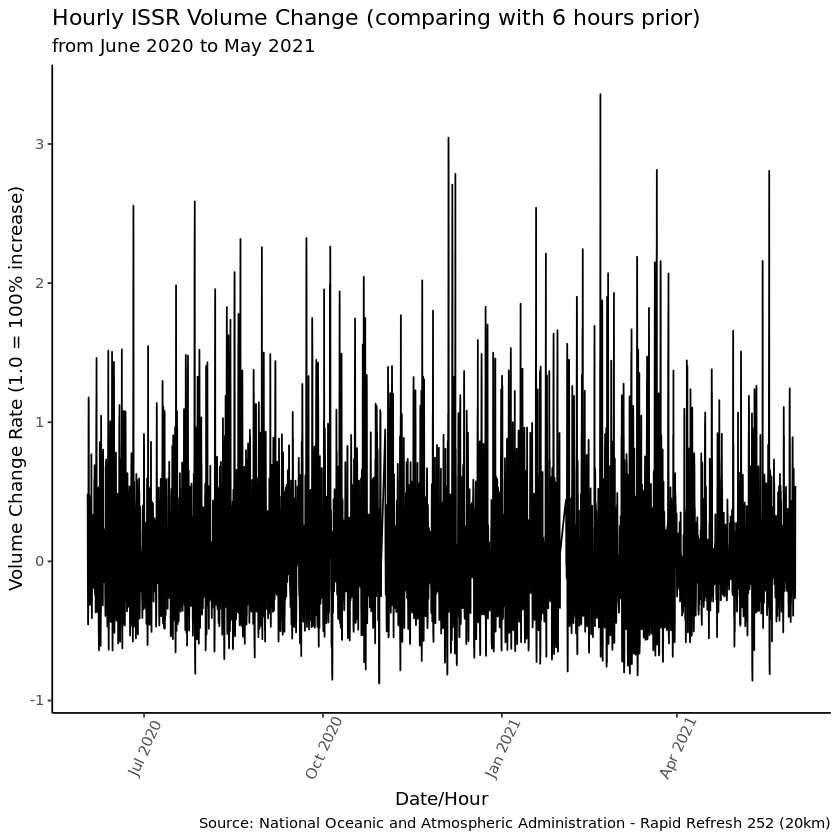

In [53]:
ggplot(df_join, aes(x= dateTime)) + 
  geom_line(aes(y= volChange_6), color= 'black') +
  labs(title= "Hourly ISSR Volume Change (comparing with 6 hours prior)", 
       subtitle= "from June 2020 to May 2021", 
       caption= "Source: National Oceanic and Atmospheric Administration - Rapid Refresh 252 (20km)",
       x= "Date/Hour",
       y= "Volume Change Rate (1.0 = 100% increase)") +
theme(axis.text.x = element_text(angle= 65, vjust= 0.6))

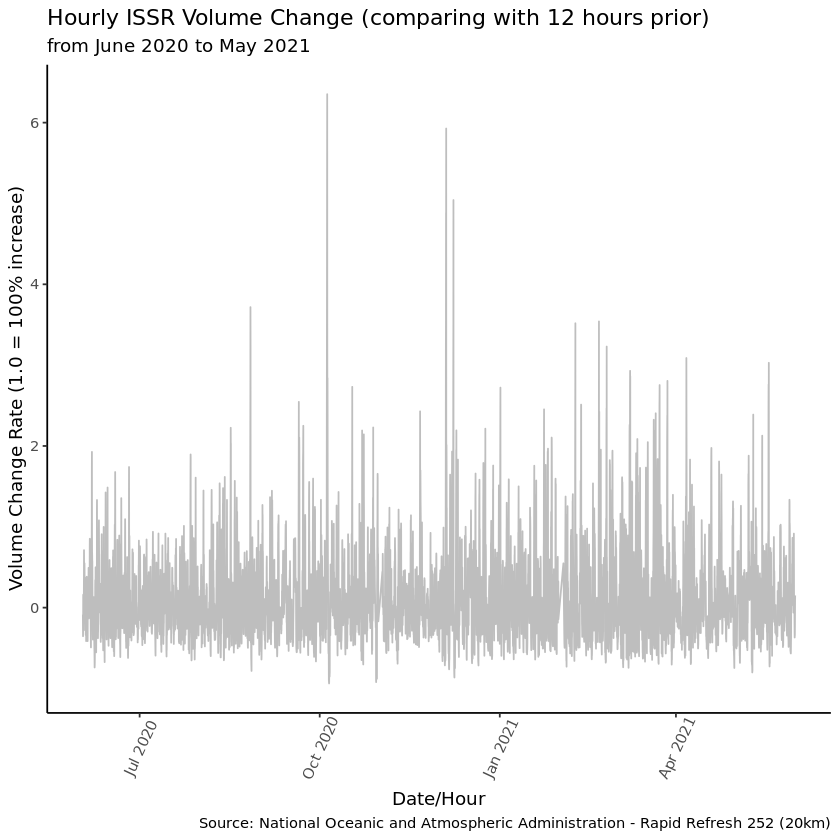

In [54]:
ggplot(df_join, aes(x= dateTime)) + 
  geom_line(aes(y= volChange_12), color= 'gray') +
  labs(title= "Hourly ISSR Volume Change (comparing with 12 hours prior)", 
       subtitle= "from June 2020 to May 2021", 
       caption= "Source: National Oceanic and Atmospheric Administration - Rapid Refresh 252 (20km)",
       x= "Date/Hour",
       y= "Volume Change Rate (1.0 = 100% increase)") +
theme(axis.text.x = element_text(angle= 65, vjust= 0.6))

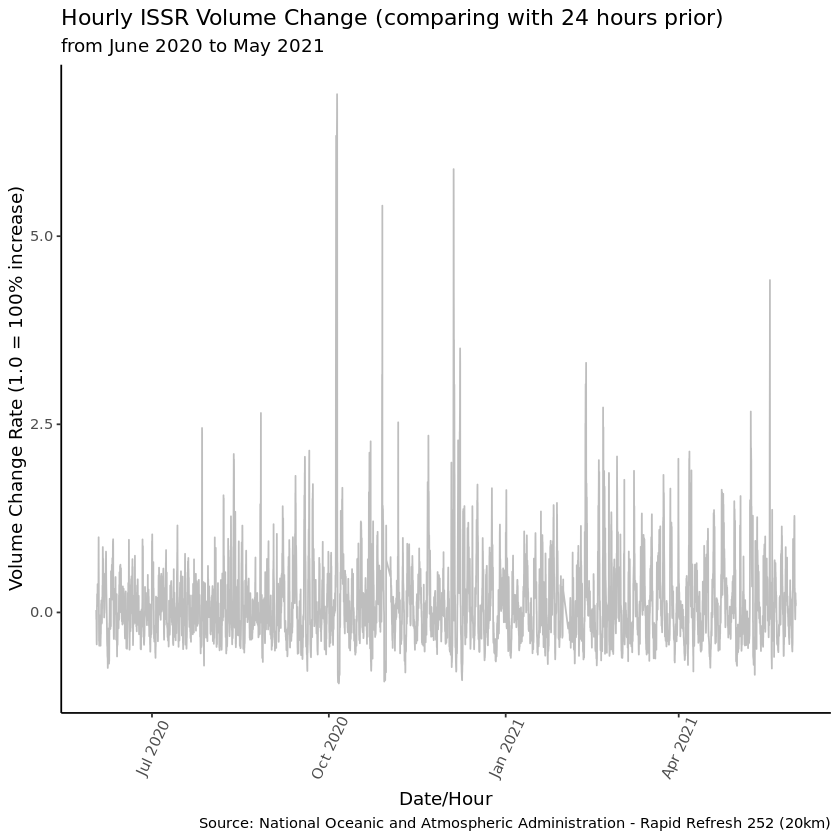

In [55]:
ggplot(df_join, aes(x= dateTime)) + 
  geom_line(aes(y= volChange_24), color= 'gray') +
  labs(title= "Hourly ISSR Volume Change (comparing with 24 hours prior)", 
       subtitle= "from June 2020 to May 2021", 
       caption= "Source: National Oceanic and Atmospheric Administration - Rapid Refresh 252 (20km)",
       x= "Date/Hour",
       y= "Volume Change Rate (1.0 = 100% increase)") +
theme(axis.text.x = element_text(angle= 65, vjust= 0.6))